In [1]:
%pylab notebook
import os
import sys
import numpy as np
import matplotlib
import serial
import pyvisa
import struct as struct
from time import sleep, time
from pylab import *
from datetime import datetime

from scipy import integrate
from scipy.special import jv
import csv
import numpy as np
import pylab as plt
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [ ]:
##############################Initialise#####################################################
nrow = 2
ncol = 3
xsize = 9.5
ysize = 4.5


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


lambda_s_width = 2
lambda_s_center = 890
lambda_i_width = 2
lambda_i_center = 1/(1/532-1/lambda_s_center)

c = 3e8

lambda_s_start = lambda_s_center-lambda_s_width/2 #starting wavelength in nm
lambda_s_end =  lambda_s_center+lambda_s_width/2 #ending wavelength in nm
lambda_i_start = lambda_i_center-lambda_i_width/2 #starting wavelength in nm
lambda_i_end =  lambda_i_center+lambda_i_width/2 #ending wavelength in nm

#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
x_locator = FixedLocator([lambda_s_center-lambda_s_width/4, lambda_s_center, lambda_s_center+lambda_s_width/4])
#x_formatter = FixedFormatter([0,r'$\pi/4$',r'$\pi/2$'])
y_locator = FixedLocator([lambda_i_center-lambda_i_width/4, lambda_i_center, lambda_i_center+lambda_i_width/4])
#y_formatter = FixedFormatter([0,.5,1.00])
#x_locator = FixedLocator([779.5, 780, 780.5])
#y_locator = FixedLocator([791.5, 792, 792.5])


fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.025, wspace=0.025)

fig.set_facecolor('w')

for i in range(0,len(axes)):
    axes[i].tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    axes[i].tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
#    axes[i].xaxis.set_major_formatter(x_formatter)
    axes[i].xaxis.set_major_locator(x_locator)
 #   axes[i,j].yaxis.set_major_formatter(y_formatter)
    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

#############################################################################################
#labels
axes[0].set_ylabel(r'$\lambda_I$ (nm)', fontsize = labelfont)
axes[0].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[1].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[2].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))


###################################
#selmaier for LiNbO3 - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 2.9804
a_y = 2.6734
b_x = 0.02047
b_y = 0.01764
c_x = 0.5981
c_y = 1.2290
d_x = 0.0666
d_y = 0.05914
e_x = 8.9543
e_y = 12.614
f_x = 416.08
f_y = 474.6


def n_x(lambda_in):
    return  0.068933*sqrt(1+a_x/((lambda_in/1000)**2-b_x)+c_x/((lambda_in/1000)**2-d_x)+ e_x/((lambda_in/1000)**2-f_x))
def n_y(lambda_in):
    return  0.068933*sqrt(1+a_y/((lambda_in/1000)**2-b_y)+c_y/((lambda_in/1000)**2-d_y)+ e_y/((lambda_in/1000)**2-f_y))
###################################



no_pts_s = 500
no_pts_i = no_pts_s

lambda_s = linspace(lambda_s_start, lambda_s_end, no_pts_s)
lambda_i = linspace(lambda_i_start, lambda_i_end, no_pts_i)

omega_i = c/lambda_i/1e-9*2*pi
omega_s = c/lambda_s/1e-9*2*pi

omega_i_m = []
omega_s_m = []

for i in range(len(omega_i)):
    omega_i_m.append(omega_i)
    omega_s_m.append(omega_s)
    
omega_i_m = array(omega_i_m).transpose()
omega_s_m = array(omega_s_m)

lambda_i_m = []
lambda_s_m = []

for i in range(len(lambda_i)):
    lambda_i_m.append(lambda_i)
    lambda_s_m.append(lambda_s)
    
lambda_i_m = array(lambda_i_m).transpose()
lambda_s_m = array(lambda_s_m)

poling_period = 4.44#in um

laser_bw = 0.005 #in nm
laser_center = 532 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(laser_center*1e-9)**2*laser_bw*1e-9

L = 10 #length of waveguide in mm
l = 75 #length of cavity in mm
r_1 = sqrt(1-0.00075)
r_2 = sqrt(1-0.055)
r_1p = 0.5
r_2p = 0.99

###########################################################Calculate dn/dw and n_g
def n_prime(n_array, w_array):
    buffer = []
    for i in range(len(n_array)):
        buffer.append(gradient(n_array[i,:], w_array[i,:]))
    return array(buffer)

def n_g_x(lambda_in, w_array):
    return add(n_x(lambda_in),w_array * n_prime(n_x(lambda_in), w_array))

def n_g_y(lambda_in, w_array):
    return n_y(lambda_in) + w_array * n_prime(n_y(lambda_in), w_array)

def n_g_z(lambda_in, w_array):
    return n_z(lambda_in) + w_array * n_prime(n_z(lambda_in), w_array)

###########################################Calculate the pump envelope

alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s_m/(2*pi),omega_i_m/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

###########################################Calculate the spectral intensity

#delta_k = (n_g_x(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_g_x(lambda_s_m, omega_s_m)/(lambda_s_m*1e-9) - 2*pi*transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k = (2*pi*1.000132*n_x(2*pi*c/add(omega_i_m, omega_s_m)*1e9)/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_x(lambda_s_m)/(lambda_s_m*1e-9) - 2*pi*(n_y((lambda_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k_lin = (2*pi*(n_x(laser_center)/laser_center*1e-9 - 1/poling_period/1e-6) - 1/c*(omega_s_m*n_x(lambda_s_m)+omega_i_m*n_y(lambda_i_m)))
#delta_k - delta_k_lin
psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

###########################################Calculate the joint spectral intensity

JSI = (psi*alpha)

axes[0].pcolor(lambda_s, lambda_i, alpha, cmap='viridis')
#axes[0].pcolor(lambda_s, lambda_i, (sin(delta_k_lin*L*1e-3/2)/(delta_k_lin*L*1e-3/2)), cmap='viridis')
axes[1].pcolor(lambda_s, lambda_i, psi, cmap='viridis')
#axes[1].plot(lambda_s, 1/(1/393-1/lambda_s), color = 'red', lw=0.5)
axes[2].pcolor(lambda_s, lambda_i, JSI**2, cmap='viridis')
#axes[2].plot(lambda_s, 1/(1/393-1/lambda_s), color = 'red', lw=0.5)

matplotlib.pyplot.tight_layout()

lft = 0.2
btm = 0.2

axes[0].text(lft, btm,r'\textbf{a)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
axes[1].text(lft, btm,r'\textbf{b)}',color = 'white',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
axes[2].text(lft, btm,r'\textbf{c)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)


#fig = plt.figure()
#ax = plt.axes(projection='3d')

#ax.plot_surface(lambda_s_m, lambda_i_m, JSI**2,cmap='viridis', edgecolor='none')

In [ ]:
##############################Initialise#####################################################
nrow = 1
ncol = 3
xsize = 10.5
ysize = 4


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


lambda_s_width = 2
lambda_s_center = 780
lambda_i_width = 2
lambda_i_center = 1/(1/393-1/lambda_s_center)

c = 3e8

lambda_s_start = lambda_s_center-lambda_s_width/2 #starting wavelength in nm
lambda_s_end =  lambda_s_center+lambda_s_width/2 #ending wavelength in nm
lambda_i_start = lambda_i_center-lambda_i_width/2 #starting wavelength in nm
lambda_i_end =  lambda_i_center+lambda_i_width/2 #ending wavelength in nm

#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
x_locator = FixedLocator([lambda_s_center-lambda_s_width/4, lambda_s_center, lambda_s_center+lambda_s_width/4])
#x_formatter = FixedFormatter([0,r'$\pi/4$',r'$\pi/2$'])
y_locator = FixedLocator([lambda_i_center-lambda_i_width/4, lambda_i_center, lambda_i_center+lambda_i_width/4])
y_formatter = FixedFormatter([791.6,792.1,792.6])
#x_locator = FixedLocator([779.5, 780, 780.5])
#y_locator = FixedLocator([791.5, 792, 792.5])


fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.025, wspace=0.005)

fig.set_facecolor('w')

for i in range(0,len(axes)):
    axes[i].tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    axes[i].tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
#    axes[i].xaxis.set_major_formatter(x_formatter)
    axes[i].xaxis.set_major_locator(x_locator)
    axes[i].yaxis.set_major_formatter(y_formatter)
    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

#############################################################################################
#labels
axes[0].set_ylabel(r'$\lambda_I$ (nm)', fontsize = labelfont)
axes[0].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[1].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[2].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################



no_pts_s = 1000
no_pts_i = no_pts_s

lambda_s = linspace(lambda_s_start, lambda_s_end, no_pts_s)
lambda_i = linspace(lambda_i_start, lambda_i_end, no_pts_i)

omega_i = c/lambda_i/1e-9*2*pi
omega_s = c/lambda_s/1e-9*2*pi

omega_i_m = []
omega_s_m = []

for i in range(len(omega_i)):
    omega_i_m.append(omega_i)
    omega_s_m.append(omega_s)
    
omega_i_m = array(omega_i_m).transpose()
omega_s_m = array(omega_s_m)

lambda_i_m = []
lambda_s_m = []

for i in range(len(lambda_i)):
    lambda_i_m.append(lambda_i)
    lambda_s_m.append(lambda_s)
    
lambda_i_m = array(lambda_i_m).transpose()
lambda_s_m = array(lambda_s_m)

poling_period = 8.35#in um

laser_bw = 0.05 #in nm
laser_center = 393 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(393e-9)**2*laser_bw*1e-9

L = 10 #length of waveguide in mm
l = 10 #length of cavity in mm
r_1 = sqrt(1-0.00075)
r_2 = sqrt(1-0.055)
r_1p = 0.5
r_2p = 0.99

###########################################################Calculate dn/dw and n_g
def n_prime(n_array, w_array):
    buffer = []
    for i in range(len(n_array)):
        buffer.append(gradient(n_array[i,:], w_array[i,:]))
    return array(buffer)

def n_g_x(lambda_in, w_array):
    return add(n_x(lambda_in),w_array * n_prime(n_x(lambda_in), w_array))

def n_g_y(lambda_in, w_array):
    return n_y(lambda_in) + w_array * n_prime(n_y(lambda_in), w_array)

def n_g_z(lambda_in, w_array):
    return n_z(lambda_in) + w_array * n_prime(n_z(lambda_in), w_array)

###########################################Calculate the pump envelope

alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s_m/(2*pi),omega_i_m/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

###########################################Calculate the spectral intensity

#delta_k = (n_g_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_g_z(lambda_s_m, omega_s_m)/(lambda_s_m*1e-9) - 2*pi*transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k = (2*pi*1.000132*n_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9)/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_z(lambda_s_m)/(lambda_s_m*1e-9) - 2*pi*(n_y((lambda_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k_lin = 2*pi*(n_y(393)/393e-9 - 1/poling_period/1e-6) - 1/c*(omega_s_m*n_z(lambda_s_m)+omega_i_m*n_y(lambda_i_m))

psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

###########################################Calculate the joint spectral intensity

JSI = (psi*alpha)

axes[0].pcolor(lambda_s, lambda_i, alpha, cmap='viridis')
#axes[0].pcolor(lambda_s, lambda_i, (sin(delta_k_lin*L*1e-3/2)/(delta_k_lin*L*1e-3/2)), cmap='viridis')
axes[1].pcolor(lambda_s, lambda_i, psi, cmap='viridis')
#axes[1].plot(lambda_s, 1/(1/393-1/lambda_s), color = 'red', lw=0.5)
axes[2].pcolor(lambda_s, lambda_i, JSI**2, cmap='viridis')
#axes[2].plot(lambda_s, 1/(1/393-1/lambda_s), color = 'red', lw=0.5)

matplotlib.pyplot.tight_layout()

lft = 0.2
btm = 0.2

axes[0].text(lft, btm,r'\textbf{a)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
axes[1].text(lft, btm,r'\textbf{b)}',color = 'white',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
axes[2].text(lft, btm,r'\textbf{c)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)


#fig = plt.figure()
#ax = plt.axes(projection='3d')

#ax.plot_surface(lambda_s_m, lambda_i_m, JSI**2,cmap='viridis', edgecolor='none')

In [ ]:
n_y(792)

In [ ]:
##############################Initialise#####################################################
nrow = 1
ncol = 3
xsize = 10.5
ysize = 4


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


lambda_s_width = 2
lambda_s_center = 780
lambda_i_width = 2
lambda_i_center = 1/(1/393-1/lambda_s_center)

c = 3e8

lambda_s_start = lambda_s_center-lambda_s_width/2 #starting wavelength in nm
lambda_s_end =  lambda_s_center+lambda_s_width/2 #ending wavelength in nm
lambda_i_start = lambda_i_center-lambda_i_width/2 #starting wavelength in nm
lambda_i_end =  lambda_i_center+lambda_i_width/2 #ending wavelength in nm

#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
x_locator = FixedLocator([lambda_s_center-lambda_s_width/4, lambda_s_center, lambda_s_center+lambda_s_width/4])
#x_formatter = FixedFormatter([0,r'$\pi/4$',r'$\pi/2$'])
y_locator = FixedLocator([lambda_i_center-lambda_i_width/4, lambda_i_center, lambda_i_center+lambda_i_width/4])
y_formatter = FixedFormatter([791.6,792.1,792.6])
#x_locator = FixedLocator([779.5, 780, 780.5])
#y_locator = FixedLocator([791.5, 792, 792.5])


fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.025, wspace=0.025)

fig.set_facecolor('w')

for i in range(0,len(axes)):
    axes[i].tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    axes[i].tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
#    axes[i].xaxis.set_major_formatter(x_formatter)
    axes[i].xaxis.set_major_locator(x_locator)
    axes[i].yaxis.set_major_formatter(y_formatter)
    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

#############################################################################################
#labels
axes[0].set_ylabel(r'$\lambda_I$ (nm)', fontsize = labelfont)
axes[0].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[1].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[2].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################



no_pts_s = 1000
no_pts_i = no_pts_s

lambda_s = linspace(lambda_s_start, lambda_s_end, no_pts_s)
lambda_i = linspace(lambda_i_start, lambda_i_end, no_pts_i)

omega_i = c/lambda_i/1e-9*2*pi
omega_s = c/lambda_s/1e-9*2*pi

omega_i_m = []
omega_s_m = []

for i in range(len(omega_i)):
    omega_i_m.append(omega_i)
    omega_s_m.append(omega_s)
    
omega_i_m = array(omega_i_m).transpose()
omega_s_m = array(omega_s_m)

lambda_i_m = []
lambda_s_m = []

for i in range(len(lambda_i)):
    lambda_i_m.append(lambda_i)
    lambda_s_m.append(lambda_s)
    
lambda_i_m = array(lambda_i_m).transpose()
lambda_s_m = array(lambda_s_m)

poling_period = 8.35#in um

laser_bw = 0.05 #in nm
laser_center = 393 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(393e-9)**2*laser_bw*1e-9

L = 10 #length of waveguide in mm
l = 10 #length of cavity in mm
r_1 = sqrt(1-0.00075)
r_2 = 0.6#sqrt(1-0.055)
r_1p = 0.5
r_2p = 0.99

###########################################################Calculate dn/dw and n_g
def n_prime(n_array, w_array):
    buffer = []
    for i in range(len(n_array)):
        buffer.append(gradient(n_array[i,:], w_array[i,:]))
    return array(buffer)

def n_g_x(lambda_in, w_array):
    return add(n_x(lambda_in),w_array * n_prime(n_x(lambda_in), w_array))

def n_g_y(lambda_in, w_array):
    return n_y(lambda_in) + w_array * n_prime(n_y(lambda_in), w_array)

def n_g_z(lambda_in, w_array):
    return n_z(lambda_in) + w_array * n_prime(n_z(lambda_in), w_array)

###########################################Calculate the pump envelope

alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s_m/(2*pi),omega_i_m/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

###########################################Calculate the spectral intensity

#delta_k = (n_g_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_g_z(lambda_s_m, omega_s_m)/(lambda_s_m*1e-9) - 2*pi*transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k = (2*pi*1.000132*n_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9)/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_z(lambda_s_m)/(lambda_s_m*1e-9) - 2*pi*(n_y((lambda_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k_lin = 2*pi*(n_y(393)/393e-9 - 1/poling_period/1e-6) - 1/c*(omega_s_m*n_z(lambda_s_m)+omega_i_m*n_y(lambda_i_m))

psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

###########################################Calculate the joint spectral intensity

JSI = (psi*alpha)

###########################################Calculate the filtering airy functions

#cavity lengths scaled for visualization ease
phase_s = omega_s_m*(n_g_z(lambda_s_m, omega_s_m)*L/10*1e-3+(l/10*1e-3-L/10*1e-3))/3e8
phase_i = omega_i_m*(transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m))*L/10*1e-3+(l/10*1e-3-L/10*1e-3)))/3e8

A = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_s)**2))

axes[0].pcolor(lambda_s, lambda_i, JSI**2, cmap='viridis')
axes[1].pcolor(lambda_s, lambda_i, A, cmap='viridis')
axes[2].pcolor(lambda_s, lambda_i, A*JSI**2, cmap='viridis')

matplotlib.pyplot.tight_layout()

lft = 0.2
btm = 0.2

axes[0].text(lft, btm,r'\textbf{a)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
axes[1].text(lft, btm,r'\textbf{b)}',color = 'white',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
axes[2].text(lft, btm,r'\textbf{c)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)


In [ ]:
##############################Initialise#####################################################
nrow = 1
ncol = 3
xsize = 10.5
ysize = 4


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


lambda_s_width = 2
lambda_s_center = 780
lambda_i_width = 2
lambda_i_center = 1/(1/393-1/lambda_s_center)

c = 3e8

lambda_s_start = lambda_s_center-lambda_s_width/2 #starting wavelength in nm
lambda_s_end =  lambda_s_center+lambda_s_width/2 #ending wavelength in nm
lambda_i_start = lambda_i_center-lambda_i_width/2 #starting wavelength in nm
lambda_i_end =  lambda_i_center+lambda_i_width/2 #ending wavelength in nm

#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
x_locator = FixedLocator([lambda_s_center-lambda_s_width/4, lambda_s_center, lambda_s_center+lambda_s_width/4])
#x_formatter = FixedFormatter([0,r'$\pi/4$',r'$\pi/2$'])
y_locator = FixedLocator([lambda_i_center-lambda_i_width/4, lambda_i_center, lambda_i_center+lambda_i_width/4])
#y_formatter = FixedFormatter([0,.5,1.00])
#x_locator = FixedLocator([779.5, 780, 780.5])
y_formatter = FixedFormatter([791.6, 792.1, 792.5])


fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.025, wspace=0.025)

fig.set_facecolor('w')

for i in range(0,len(axes)):
    axes[i].tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    axes[i].tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
#    axes[i].xaxis.set_major_formatter(x_formatter)
    axes[i].xaxis.set_major_locator(x_locator)
    axes[i].yaxis.set_major_formatter(y_formatter)
    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

#############################################################################################
#labels
axes[0].set_ylabel(r'$\lambda_I$ (nm)', fontsize = labelfont)
axes[0].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[1].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[2].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################



no_pts_s = 500
no_pts_i = no_pts_s

lambda_s = linspace(lambda_s_start, lambda_s_end, no_pts_s)
lambda_i = linspace(lambda_i_start, lambda_i_end, no_pts_i)

omega_i = c/lambda_i/1e-9*2*pi
omega_s = c/lambda_s/1e-9*2*pi

omega_i_m = []
omega_s_m = []

for i in range(len(omega_i)):
    omega_i_m.append(omega_i)
    omega_s_m.append(omega_s)
    
omega_i_m = array(omega_i_m).transpose()
omega_s_m = array(omega_s_m)

lambda_i_m = []
lambda_s_m = []

for i in range(len(lambda_i)):
    lambda_i_m.append(lambda_i)
    lambda_s_m.append(lambda_s)
    
lambda_i_m = array(lambda_i_m).transpose()
lambda_s_m = array(lambda_s_m)

poling_period = 8.35#in um

laser_bw = 0.05 #in nm
laser_center = 393 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(393e-9)**2*laser_bw*1e-9

L = 10 #length of waveguide in mm
l = 10 #length of cavity in mm
r_1 = sqrt(1-0.00075)
r_2 = 0.6#sqrt(1-0.055)
r_1p = 0.5
r_2p = 0.99

BP_bw_s = 1 #in nm
BP_center_s = 792 #in nm
BP_cnt_f_s = c/BP_center_s/1e-9

BP_HWHM_s = c/(BP_center_s*1e-9)**2*BP_bw_s*1e-9

BP_bw_i = 1 #in nm
BP_center_i = 780 #in nm
BP_cnt_f_i = c/BP_center_i/1e-9

BP_HWHM_i = c/(BP_center_i*1e-9)**2*BP_bw_i*1e-9

###########################################################Calculate dn/dw and n_g
def n_prime(n_array, w_array):
    buffer = []
    for i in range(len(n_array)):
        buffer.append(gradient(n_array[i,:], w_array[i,:]))
    return array(buffer)

def n_g_x(lambda_in, w_array):
    return add(n_x(lambda_in),w_array * n_prime(n_x(lambda_in), w_array))

def n_g_y(lambda_in, w_array):
    return n_y(lambda_in) + w_array * n_prime(n_y(lambda_in), w_array)

def n_g_z(lambda_in, w_array):
    return n_z(lambda_in) + w_array * n_prime(n_z(lambda_in), w_array)

###########################################Calculate the pump envelope

alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s_m/(2*pi),omega_i_m/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

###########################################Calculate the spectral intensity

#delta_k = (n_g_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_g_z(lambda_s_m, omega_s_m)/(lambda_s_m*1e-9) - 2*pi*transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k = (2*pi*1.000132*n_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9)/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_z(lambda_s_m)/(lambda_s_m*1e-9) - 2*pi*(n_y((lambda_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k_lin = 2*pi*(n_y(393)/393e-9 - 1/poling_period/1e-6) - 1/c*(omega_s_m*n_z(lambda_s_m)+omega_i_m*n_y(lambda_i_m))

psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

###########################################Calculate the joint spectral intensity

JSI = (psi*alpha)

###########################################Calculate the filtering airy functions

#cavity lengths scaled for visualization ease
phase_s = omega_s_m*(n_g_z(lambda_s_m, omega_s_m)*L/10*1e-3+(l/10*1e-3-L/10*1e-3))/3e8
phase_i = omega_i_m*(transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m))*L/10*1e-3+(l/10*1e-3-L/10*1e-3)))/3e8

A_i = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_i)**2))
A_s = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_s)**2))

BP_i = exp(-1*array([x - BP_cnt_f_i for x in (omega_i_m/(2*pi))])**2/(2*(2*BP_HWHM_i/2.35482)**2))
BP_s = exp(-1*array([x - BP_cnt_f_s for x in (omega_s_m/(2*pi))])**2/(2*(2*BP_HWHM_s/2.35482)**2))

BP = BP_i*BP_s

axes[0].pcolor(lambda_s, lambda_i, JSI**2, cmap='viridis')
axes[1].pcolor(lambda_s, lambda_i, A_i*A_s, cmap='viridis')
#axes[0].plot(lambda_s, (A_i*A_s)[:,1725],label = '2')
#axes[0].plot(lambda_s, (A_i*A_s)[:,1726],label = '3')
#axes[0].plot(lambda_s, (A_i*A_s)[:,1727],label = '4')
#axes[0].plot(lambda_s, (A_i*A_s)[:,1728],label = '5')
axes[2].pcolor(lambda_s, lambda_i, A_i*A_s*JSI**2, cmap='viridis')

matplotlib.pyplot.tight_layout()

lft = 0.2
btm = 0.2
#axes[0].legend()
axes[0].text(lft, btm,r'\textbf{a)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
axes[1].text(lft, btm,r'\textbf{b)}',color = 'white',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
axes[2].text(lft, btm,r'\textbf{c)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)


In [ ]:
n_g_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))[500, 500]

In [ ]:
##############################Initialise#####################################################
nrow = 1
ncol = 3
xsize = 10.5
ysize = 4


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


lambda_s_width = 2
lambda_s_center = 780
lambda_i_width = 2
lambda_i_center = 1/(1/393-1/lambda_s_center)

c = 3e8

lambda_s_start = lambda_s_center-lambda_s_width/2 #starting wavelength in nm
lambda_s_end =  lambda_s_center+lambda_s_width/2 #ending wavelength in nm
lambda_i_start = lambda_i_center-lambda_i_width/2 #starting wavelength in nm
lambda_i_end =  lambda_i_center+lambda_i_width/2 #ending wavelength in nm

#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
x_locator = FixedLocator([lambda_s_center-lambda_s_width/4, lambda_s_center, lambda_s_center+lambda_s_width/4])
#x_formatter = FixedFormatter([0,r'$\pi/4$',r'$\pi/2$'])
y_locator = FixedLocator([lambda_i_center-lambda_i_width/4, lambda_i_center, lambda_i_center+lambda_i_width/4])
#y_formatter = FixedFormatter([0,.5,1.00])
#x_locator = FixedLocator([779.5, 780, 780.5])
y_formatter = FixedFormatter([791.6, 792.1, 792.5])


fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.025, wspace=0.025)

fig.set_facecolor('w')

for i in range(0,len(axes)):
    axes[i].tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    axes[i].tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
#    axes[i].xaxis.set_major_formatter(x_formatter)
    axes[i].xaxis.set_major_locator(x_locator)
    axes[i].yaxis.set_major_formatter(y_formatter)
    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

#############################################################################################
#labels
axes[0].set_ylabel(r'$\lambda_I$ (nm)', fontsize = labelfont)
axes[0].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[1].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[2].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################



no_pts_s = 500
no_pts_i = no_pts_s

lambda_s = linspace(lambda_s_start, lambda_s_end, no_pts_s)
lambda_i = linspace(lambda_i_start, lambda_i_end, no_pts_i)

omega_i = c/lambda_i/1e-9*2*pi
omega_s = c/lambda_s/1e-9*2*pi

omega_i_m = []
omega_s_m = []

for i in range(len(omega_i)):
    omega_i_m.append(omega_i)
    omega_s_m.append(omega_s)
    
omega_i_m = array(omega_i_m).transpose()
omega_s_m = array(omega_s_m)

lambda_i_m = []
lambda_s_m = []

for i in range(len(lambda_i)):
    lambda_i_m.append(lambda_i)
    lambda_s_m.append(lambda_s)
    
lambda_i_m = array(lambda_i_m).transpose()
lambda_s_m = array(lambda_s_m)

poling_period = 8.35#in um

laser_bw = 0.05 #in nm
laser_center = 393 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(393e-9)**2*laser_bw*1e-9

L = 10 #length of waveguide in mm
l = 10 #length of cavity in mm
r_1 = sqrt(1-0.00075)
r_2 = 0.6#sqrt(1-0.055)
r_1p = 0.5
r_2p = 0.99

BP_bw_s = 1 #in nm
BP_center_s = 792 #in nm
BP_cnt_f_s = c/BP_center_s/1e-9

BP_HWHM_s = c/(BP_center_s*1e-9)**2*BP_bw_s*1e-9

BP_bw_i = 1 #in nm
BP_center_i = 780 #in nm
BP_cnt_f_i = c/BP_center_i/1e-9

BP_HWHM_i = c/(BP_center_i*1e-9)**2*BP_bw_i*1e-9

###########################################################Calculate dn/dw and n_g
def n_prime(n_array, w_array):
    buffer = []
    for i in range(len(n_array)):
        buffer.append(gradient(n_array[i,:], w_array[i,:]))
    return array(buffer)

def n_g_x(lambda_in, w_array):
    return add(n_x(lambda_in),w_array * n_prime(n_x(lambda_in), w_array))

def n_g_y(lambda_in, w_array):
    return n_y(lambda_in) + w_array * n_prime(n_y(lambda_in), w_array)

def n_g_z(lambda_in, w_array):
    return n_z(lambda_in) + w_array * n_prime(n_z(lambda_in), w_array)

###########################################Calculate the pump envelope

alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s_m/(2*pi),omega_i_m/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

###########################################Calculate the spectral intensity

#delta_k = (n_g_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_g_z(lambda_s_m, omega_s_m)/(lambda_s_m*1e-9) - 2*pi*transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k = (2*pi*1.000132*n_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9)/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_z(lambda_s_m)/(lambda_s_m*1e-9) - 2*pi*(n_y((lambda_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k_lin = 2*pi*(n_y(393)/393e-9 - 1/poling_period/1e-6) - 1/c*(omega_s_m*n_z(lambda_s_m)+omega_i_m*n_y(lambda_i_m))

psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

###########################################Calculate the joint spectral intensity

JSI = (psi*alpha)

###########################################Calculate the filtering airy functions

#cavity lengths scaled for visualization ease
phase_s = omega_s_m*(n_g_z(lambda_s_m, omega_s_m)*L/10*1e-3+(l/10*1e-3-L/10*1e-3))/3e8
phase_i = omega_i_m*(transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m))*L/10*1e-3+(l/10*1e-3-L/10*1e-3)))/3e8
phase_p = add(omega_i_m, omega_s_m)*(n_g_x(c/add(omega_i_m/(2*pi), omega_s_m/(2*pi))*1e9, add(omega_i_m, omega_s_m))*L/10*1e-3+(l/10*1e-3-L/10*1e-3))/3e8

A_i = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_i)**2))
A_s = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_s)**2))
A_p = ((1-r_2p**2)/(1-r_1p*r_2p)**2) * (1)/(1+(4*r_1p*r_2p/(1-r_1p*r_2p)**2*sin(phase_p)**2))

axes[0].pcolor(lambda_s, lambda_i,  A_i*A_s*JSI**2, cmap='viridis')
axes[1].pcolor(lambda_s, lambda_i, A_p, cmap='viridis')
axes[2].pcolor(lambda_s, lambda_i,A_i*A_s*A_p*JSI**2, cmap='viridis')

matplotlib.pyplot.tight_layout()

lft = 0.2
btm = 0.2

axes[0].text(lft, btm,r'\textbf{a)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
axes[1].text(lft, btm,r'\textbf{b)}',color = 'white',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
axes[2].text(lft, btm,r'\textbf{c)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)


In [ ]:
##############################Initialise#####################################################
nrow = 1
ncol = 3
xsize = 9
ysize = 3.5


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
#x_locator = FixedLocator([777, 780, 783])
#x_formatter = FixedFormatter([0,r'$\pi/4$',r'$\pi/2$'])
#y_locator = FixedLocator([789, 792, 795])
#y_formatter = FixedFormatter([0,.5,1.00])
x_locator = FixedLocator([779.5, 780, 780.5])
y_locator = FixedLocator([791.5, 792, 792.5])

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.025, wspace=0.025)

fig.set_facecolor('w')

for i in range(0,len(axes)):
    axes[i].tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    axes[i].tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
#    axes[i].xaxis.set_major_formatter(x_formatter)
    axes[i].xaxis.set_major_locator(x_locator)
 #   axes[i,j].yaxis.set_major_formatter(y_formatter)
    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
#axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

#############################################################################################
#labels
axes[0].set_ylabel(r'$\lambda_I$ (nm)', fontsize = labelfont)
axes[0].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[1].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[2].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################

c = 3e8
#lambda_s_start = 720 #starting wavelength in nm
#lambda_s_end =  800 #ending wavelength in nm
#lambda_i_start = 720 #starting wavelength in nm
#lambda_i_end =  800 #ending wavelength in nm
#lambda_s_start = 778 #starting wavelength in nm
#lambda_s_end =  782 #ending wavelength in nm
#lambda_i_start = 790 #starting wavelength in nm
#lambda_i_end =  794 #ending wavelength in nm
#lambda_s_start = 779 #starting wavelength in nm
#lambda_s_end =  781 #ending wavelength in nm
#lambda_i_start = 791 #starting wavelength in nm
#lambda_i_end =  793 #ending wavelength in nm

lambda_s_start = 780 #starting wavelength in nm
lambda_s_end =  780.165 #ending wavelength in nm
lambda_i_start = 792 #starting wavelength in nm
lambda_i_end =  792.165 #ending wavelength in nm
no_pts_s = 1000
no_pts_i = no_pts_s

lambda_i = linspace(lambda_s_start, lambda_s_end, no_pts_i)
lambda_s = linspace(lambda_i_start, lambda_i_end, no_pts_s)

omega_i = c/lambda_i/1e-9*2*pi
omega_s = c/lambda_s/1e-9*2*pi

omega_i_m = []
omega_s_m = []

for i in range(len(omega_i)):
    omega_i_m.append(omega_i)
    omega_s_m.append(omega_s)
    
omega_i_m = array(omega_i_m).transpose()
omega_s_m = array(omega_s_m)

lambda_i_m = []
lambda_s_m = []

for i in range(len(lambda_i)):
    lambda_i_m.append(lambda_i)
    lambda_s_m.append(lambda_s)
    
lambda_i_m = array(lambda_i_m).transpose()
lambda_s_m = array(lambda_s_m)

BP_bw_s = 0.05 #in nm
BP_center_s = 792 #in nm
BP_cnt_f_s = c/BP_center_s/1e-9

BP_HWHM_s = c/(BP_center_s*1e-9)**2*BP_bw_s*1e-9

BP_bw_i = 0.05 #in nm
BP_center_i = 780 #in nm
BP_cnt_f_i = c/BP_center_i/1e-9

BP_HWHM_i = c/(BP_center_i*1e-9)**2*BP_bw_i*1e-9


B = []
B1 = []
As = []
    
poling_period = 8.3462 #in um

laser_bw = 0.05 #in nm
laser_center = 393 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(393e-9)**2*laser_bw*1e-9

L = 10 #length of waveguide in mm
l = 10 #length of cavity in mm
r_1 = sqrt(1-0.00075)
r_2 = sqrt(1-0.055)
r_1p = 0.5
r_2p = 0.99

BP_bw_s = 1 #in nm
BP_center_s = 792 #in nm
BP_cnt_f_s = c/BP_center_s/1e-9

BP_HWHM_s = c/(BP_center_s*1e-9)**2*BP_bw_s*1e-9

BP_bw_i = 1 #in nm
BP_center_i = 780 #in nm
BP_cnt_f_i = c/BP_center_i/1e-9

BP_HWHM_i = c/(BP_center_i*1e-9)**2*BP_bw_i*1e-9



###########################################################Calculate dn/dw and n_g
def n_prime(n_array, w_array):
    buffer = []
    for i in range(len(n_array)):
        buffer.append(gradient(n_array[i,:], w_array[i,:]))
    return array(buffer)

def n_g_x(lambda_in, w_array):
    return add(n_x(lambda_in),w_array * n_prime(n_x(lambda_in), w_array))

def n_g_y(lambda_in, w_array):
    return n_y(lambda_in) + w_array * n_prime(n_y(lambda_in), w_array)

def n_g_z(lambda_in, w_array):
    return n_z(lambda_in) + w_array * n_prime(n_z(lambda_in), w_array)

###########################################Calculate the pump envelope

for j in tqdm(range(len(r_2))):
    ################################################BP filter
    
    BP_i = exp(-1*array([x - BP_cnt_f_i for x in (omega_i_m/(2*pi))])**2/(2*(2*BP_HWHM_i/2.35482)**2))
    BP_s = exp(-1*array([x - BP_cnt_f_s for x in (omega_s_m/(2*pi))])**2/(2*(2*BP_HWHM_s/2.35482)**2))

    BP = BP_s

    ###########################################Calculate the pump envelope

    alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s_m/(2*pi),omega_i_m/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

    ###########################################Calculate the spectral intensity

    delta_k = (n_g_x(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))/((2*pi*c/add(omega_i_m, omega_s_m))) - n_g_x(lambda_s_m, omega_s_m)/(lambda_s_m*1e-9) - transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)

    psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

    ###########################################Calculate the joint spectral intensity

    JSI = (psi*alpha)

    ###########################################Calculate the filtering airy functions

    phase_s = omega_s_m*(n_g_x(lambda_s_m, omega_s_m)*L*1e-3+(l*1e-3-L*1e-3))/3e8
    phase_i = omega_i_m*(transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m))*L*1e-3+(l*1e-3-L*1e-3)))/3e8
    phase_p = add(omega_i_m, omega_s_m)*(n_g_x(c/add(omega_i_m/(2*pi)*1.0021, omega_s_m/(2*pi))*1e9, add(omega_i_m, omega_s_m))*L*1e-3+(l*1e-3-L*1e-3))/3e8

    A_i = ((1-r_2[j]**2)/(1-r_1*r_2[j])**2) * (1)/(1+(4*r_1*r_2[j]/(1-r_1*r_2[j])**2*sin(phase_i)**2))
    A_s = ((1-r_2[j]**2)/(1-r_1*r_2[j])**2) * (1)/(1+(4*r_1*r_2[j]/(1-r_1*r_2[j])**2*sin(phase_s)**2))
    A_p = ((1-r_2[j]**2)/(1-r_1p*r_2[j])**2) * (1)/(1+(4*r_1p*r_2[j]/(1-r_1p*r_2[j])**2*sin(phase_p)**2))

    k_prime_s = 1/c*n_prime((n_g_x(lambda_s_m, omega_s_m)),omega_s_m)
    k_prime_i = transpose(1/c*n_prime(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)),transpose(omega_i_m)))
    
    S = sqrt((1-r_1p**2))*A_i*A_s*A_p*JSI**2

    buffer = []

    for i in range(len(S)):
        buffer.append(integrate.simps(S[i,:], omega_s))

    B.append(1/laser_bw*integrate.simps(buffer, omega_i))
    As.append(A_s[225,:])

    
axes[0].plot(r_2, array(B)/B[0], label = 'simps')
axes[1].plot(lambda_i, array(As)[0,:], label='0')
axes[1].plot(lambda_i, array(As)[-1,:], label='0')
axes[1].plot(lambda_i, array(As)[1,:], label='0')
#axes[2].pcolor(lambda_i, lambda_s, S)

matplotlib.pyplot.tight_layout()

lft = 0.2
btm = 0.2

axes[0].text(lft, btm,r'\textbf{a)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
axes[1].text(lft, btm,r'\textbf{b)}',color = 'white',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
axes[2].text(lft, btm,r'\textbf{c)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)
axes[1].legend()
axes[0].legend()

In [ ]:
##############################Initialise#####################################################
nrow = 1
ncol = 3
xsize = 9
ysize = 3.5


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
#x_locator = FixedLocator([777, 780, 783])
#x_formatter = FixedFormatter([0,r'$\pi/4$',r'$\pi/2$'])
#y_locator = FixedLocator([789, 792, 795])
#y_formatter = FixedFormatter([0,.5,1.00])
x_locator = FixedLocator([779.5, 780, 780.5])
y_locator = FixedLocator([791.5, 792, 792.5])

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.025, wspace=0.025)

fig.set_facecolor('w')

for i in range(0,len(axes)):
    axes[i].tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    axes[i].tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
#    axes[i].xaxis.set_major_formatter(x_formatter)
    axes[i].xaxis.set_major_locator(x_locator)
 #   axes[i,j].yaxis.set_major_formatter(y_formatter)
    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
#axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

#############################################################################################
#labels
axes[0].set_ylabel(r'$\lambda_I$ (nm)', fontsize = labelfont)
axes[0].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[1].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)
axes[2].set_xlabel(r'$\lambda_S$ (nm)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################

c = 3e8
#lambda_s_start = 720 #starting wavelength in nm
#lambda_s_end =  800 #ending wavelength in nm
#lambda_i_start = 720 #starting wavelength in nm
#lambda_i_end =  800 #ending wavelength in nm
lambda_s_start = 780 #starting wavelength in nm
lambda_s_end =  780 #ending wavelength in nm
lambda_i_start = 786 #starting wavelength in nm
lambda_i_end =  798 #ending wavelength in nm
#lambda_s_start = 779 #starting wavelength in nm
#lambda_s_end =  781 #ending wavelength in nm
#lambda_i_start = 791 #starting wavelength in nm
#lambda_i_end =  793 #ending wavelength in nm

#lambda_s_start = 779.9 #starting wavelength in nm
#lambda_s_end =  780.065 #ending wavelength in nm
#lambda_i_start = 791.9 #starting wavelength in nm
#lambda_i_end =  792.065 #ending wavelength in nm
no_pts_s = 1000000
no_pts_i = 1

lambda_i = linspace(lambda_s_start, lambda_s_end, no_pts_i)
lambda_s = linspace(lambda_i_start, lambda_i_end, no_pts_s)

omega_i = c/lambda_i/1e-9*2*pi
omega_s = c/lambda_s/1e-9*2*pi

#omega_i_m = []
#omega_s_m = []

#for i in range(len(omega_i)):
#    omega_i_m.append(omega_i)
#    omega_s_m.append(omega_s)
    
#omega_i_m = array(omega_i_m).transpose()
#omega_s_m = array(omega_s_m)
#
#lambda_i_m = []
#lambda_s_m = []

#for i in range(len(lambda_i)):
#    lambda_i_m.append(lambda_i)
#    lambda_s_m.append(lambda_s)
    
#lambda_i_m = array(lambda_i_m).transpose()
#lambda_s_m = array(lambda_s_m)

poling_period = 8.18 #in um

laser_bw = 0.05 #in nm
laser_center = 393 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(laser_center*1e-9)**2*laser_bw*1e-9

BP_bw_s = 1 #in nm
BP_center_s = 792 #in nm
BP_cnt_f_s = c/BP_center_s/1e-9

BP_HWHM_s = c/(BP_center_s*1e-9)**2*BP_bw_s*1e-9

BP_bw_i = 1 #in nm
BP_center_i = 780 #in nm
BP_cnt_f_i = c/BP_center_i/1e-9

BP_HWHM_i = c/(BP_center_i*1e-9)**2*BP_bw_i*1e-9

L = 1 #length of waveguide in mm
l = 1 #length of cavity in mm
r_1 = 1
r_2 = linspace(0,0.94,20)
B = []
B1 = []
Ss = []
    
###########################################################Calculate dn/dw
def n_prime(n_array, w_array):
    buffer = []
    if len(n_array) == 1:
        buffer.append(gradient(n_array, w_array)) 
    else:
        for i in range(len(n_array)):
            buffer.append(gradient(n_array[i,:], w_array[i,:]))
    return array(buffer)
###########################################################
for j in tqdm(range(len(r_2))):
    alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s/(2*pi),omega_i/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

    BP_i = exp(-1*array([x - BP_cnt_f_i for x in (omega_i/(2*pi))])**2/(2*(2*BP_HWHM_i/2.35482)**2))
    BP_s = exp(-1*array([x - BP_cnt_f_s for x in (omega_s/(2*pi))])**2/(2*(2*BP_HWHM_s/2.35482)**2))

    BP = BP_i*BP_s

    ###########################################Calculate the spectral intensity

    delta_k = 2*pi*(n_x(c/add(omega_i/(2*pi), omega_s/(2*pi))*1e9)/((c/add(omega_i/(2*pi), omega_s/(2*pi)))) - n_x(lambda_s)/(lambda_s*1e-9)*1.0274 - n_y(lambda_i)/(lambda_i*1e-9)*1.0067 - 1/poling_period/1e-6)

    psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

    ###########################################Calculate the joint spectral intensity

    JSI = (psi*alpha)

    phase_s = omega_s*(n_x(lambda_s)*L*1e-3+(l*1e-3-L*1e-3))/3e8
    phase_i = omega_i*(n_y(lambda_i)*L*1e-3+(l*1e-3-L*1e-3))/3e8

    A_i = ((1-r_2[j]**2)/(1-r_1*r_2[j])**2) * (1)/(1+(4*r_1*r_2[j]/(1-r_1*r_2[j])**2*sin(phase_i)**2))
    A_s = ((1-r_2[j]**2)/(1-r_1*r_2[j])**2) * (1)/(1+(4*r_1*r_2[j]/(1-r_1*r_2[j])**2*sin(phase_s)**2))

    k_prime_s = 1/c*n_prime((n_x(lambda_s_m)),omega_s_m)
    #_prime_i = (1/c*n_prime((n_y(lambda_i)),(omega_i)))
    
    S = A_s**2*JSI**2
    Ss.append(S)

    buffer = []

    buffer.append(integrate.simps(S,omega_s[::-1]))

    B.append(buffer)
    
axes[0].plot(r_2, array(B)/B[0], label = 'simps')
axes[1].plot(lambda_s, array(Ss)[0,:], label='0')
axes[1].plot(lambda_s, array(Ss)[-1,:], label='0.95')
axes[2].plot(lambda_s, JSI**2)

matplotlib.pyplot.tight_layout()

lft = 0.2
btm = 0.2

axes[0].text(lft, btm,r'\textbf{a)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
axes[1].text(lft, btm,r'\textbf{b)}',color = 'white',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
axes[2].text(lft, btm,r'\textbf{c)}',color = 'white', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)
axes[1].legend()
axes[0].legend()

<ipython-input-8-aefe17dec6ea>:11: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


<IPython.core.display.Javascript object>


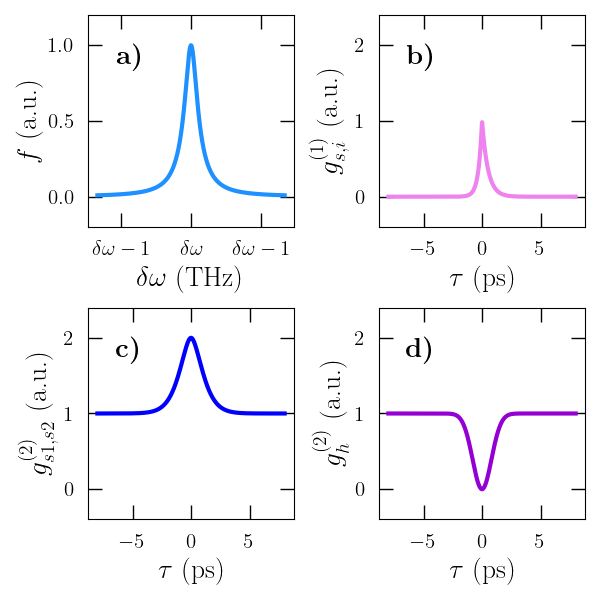

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.2, 0.8, '\\textbf{d)}')

In [8]:
##############################Initialise#####################################################
nrow = 2
ncol = 2
xsize = 6
ysize = 6


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10

lambda_s_width = 2
lambda_s_center = 780
lambda_i_width = 2
lambda_i_center = 1/(1/393-1/lambda_s_center)

c = 3e8

lambda_s_start = lambda_s_center-lambda_s_width/2 #starting wavelength in nm
lambda_s_end =  lambda_s_center+lambda_s_width/2 #ending wavelength in nm
lambda_i_start = lambda_i_center-lambda_i_width/2 #starting wavelength in nm
lambda_i_end =  lambda_i_center+lambda_i_width/2 #ending wavelength in nm

#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
#x_locator = FixedLocator([777, 780, 783])
x_formatter_w = FixedFormatter([r'$\delta\omega-1$',r'$\delta\omega$', r'$\delta\omega-1$'])
#y_locator = FixedLocator([789, 792, 795])
#y_formatter = FixedFormatter([0,.5,1.00])
x_locator_tau = FixedLocator([-5, 0, 5])
x_locator_w = FixedLocator([-10, 0, 10])
y_locator_tau = FixedLocator([0, 1, 2])
y_locator_w = FixedLocator([0, 0.5 , 1])

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.025, wspace=0.025)

fig.set_facecolor('w')

for i in range(0,nrow):
    for j in range(0, ncol):
        axes[i,j].tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
        axes[i,j].tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
        axes[i,j].tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
        axes[i,j].tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    #    axes[i].xaxis.set_major_formatter(x_formatter)
    #    axes[i].xaxis.set_major_locator(x_locator)
     #   axes[i,j].yaxis.set_major_formatter(y_formatter)
    #    axes[i].yaxis.set_major_locator(y_locator)
    #    axes[i].set_xlim(-15,105)
    #    axes[i].set_ylim(-0.1,2.6)
    
#axes[1].set_yticklabels([])
#axes[2].set_yticklabels([])

axes[0,0].xaxis.set_major_locator(x_locator_w)
axes[0,0].xaxis.set_major_formatter(x_formatter_w)
axes[1,0].xaxis.set_major_locator(x_locator_tau)
axes[1,1].xaxis.set_major_locator(x_locator_tau)
axes[0,1].xaxis.set_major_locator(x_locator_tau)
axes[0,0].yaxis.set_major_locator(y_locator_w)
axes[1,0].yaxis.set_major_locator(y_locator_tau)
axes[1,1].yaxis.set_major_locator(y_locator_tau)
axes[0,1].yaxis.set_major_locator(y_locator_tau)

axes[0,1].set_ylim(-0.4,2.4)
axes[1,1].set_ylim(-0.4,2.4)
axes[1,0].set_ylim(-0.4,2.4)
axes[0,0].set_ylim(-0.2,1.2)


#############################################################################################
#labels
axes[0,0].set_ylabel(r'$f$ (a.u.)', fontsize = labelfont)
axes[0,1].set_ylabel(r'$g^{(1)}_{s,i}$ (a.u.)', fontsize = labelfont)
axes[1,0].set_ylabel(r'$g^{(2)}_{s1,s2}$ (a.u.)', fontsize = labelfont)
axes[1,1].set_ylabel(r'$g^{(2)}_{h}$ (a.u.)', fontsize = labelfont)
axes[0,0].set_xlabel(r'$\delta \omega$  (THz)' , fontsize = labelfont)
axes[0,1].set_xlabel(r'$\tau$  (ps)', fontsize = labelfont)
axes[1,0].set_xlabel(r'$\tau$  (ps)', fontsize = labelfont)
axes[1,1].set_xlabel(r'$\tau$  (ps)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################


no_pts_s = 1000
no_pts_i = no_pts_s

lambda_s = linspace(lambda_s_start, lambda_s_end, no_pts_s)
lambda_i = linspace(lambda_i_start, lambda_i_end, no_pts_i)

omega_i = c/lambda_i/1e-9*2*pi
omega_s = c/lambda_s/1e-9*2*pi

poling_period = 8.315 #in um

signal_bw = 4 #in nm
signal_center = 780 #in nm,
signal_cnt_f = c/signal_center/1e-9
signal_FWHM = c/(signal_center*1e-9)**2*signal_bw*1e-9

idler_bw = 7 #in nm
idler_center = 792 #in nm,
idler_cnt_f = c/idler_center/1e-9
idler_FWHM = c/(idler_center*1e-9)**2*idler_bw*1e-9

dw = linspace(-4*idler_FWHM,4*idler_FWHM, no_pts_s)

gamma_s = signal_FWHM/2
gamma_i = idler_FWHM/2
tau = linspace(-8e-12, 8e-12, no_pts_s)

JSI_s = gamma_s/(gamma_s+1j*(dw))
JSI_i = gamma_i/(gamma_i+1j*(dw))

JSI = (JSI_s*conj(JSI_i))
g_1 = heaviside(tau,0)*exp(-2*gamma_s*tau)+heaviside(-tau,1)*exp(2*gamma_i*tau)
g_2 = 1 + (exp(-gamma_s*sqrt(tau**2))*(1+gamma_s*sqrt(tau**2)))**2
g_2h = 1 - exp(-2*(gamma_s*gamma_i*tau/(gamma_s+gamma_i))**2)

###########################################Calculate the filtering airy functions
tau = array(tau)[numpy.argsort(array(tau))]
g_1 = array(g_1)[numpy.argsort(array(tau))]


axes[0,0].plot(dw*1e-12, JSI, color = 'dodgerblue', lw = 3)
axes[0,1].plot(tau*1e12, g_1, color = 'violet', lw = 3)
axes[1,0].plot(tau*1e12, g_2, color = 'blue', lw = 3)
axes[1,1].plot(tau*1e12, g_2h, color = 'darkviolet', lw = 3)
#axes[2].pcolor(lambda_i, lambda_s,A_i*A_s*A_p*JSI**2, cmap='viridis')
#axes[1].set_xlim(-10,10)
matplotlib.pyplot.tight_layout()

lft = 0.2
btm = 0.8

axes[0,0].text(lft, btm,r'\textbf{a)}',color = 'black', horizontalalignment='center', verticalalignment='center', transform = axes[0,0].transAxes, fontsize = labelfont)
axes[0,1].text(lft, btm,r'\textbf{b)}',color = 'black',horizontalalignment='center', verticalalignment='center' , transform = axes[0,1].transAxes, fontsize = labelfont)
axes[1,0].text(lft, btm,r'\textbf{c)}',color = 'black', horizontalalignment='center', verticalalignment='center', transform = axes[1,0].transAxes, fontsize = labelfont)
axes[1,1].text(lft, btm,r'\textbf{d)}',color = 'black', horizontalalignment='center', verticalalignment='center', transform = axes[1,1].transAxes, fontsize = labelfont)


<ipython-input-5-d7f3b5e8a123>:11: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


<IPython.core.display.Javascript object>


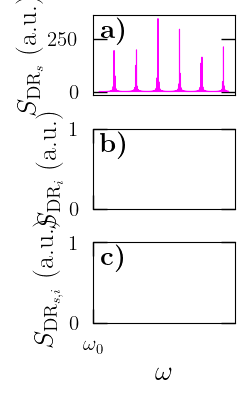

<ipython-input-5-d7f3b5e8a123>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].xaxis.set_major_formatter(x_formatter)


Text(0.15, 0.8, '\\textbf{c)}')

In [5]:
##############################Initialise#####################################################
nrow = 3
ncol = 1
xsize = 2.5
ysize = 4


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


lambda_s_width = 0.5
lambda_s_center = 780
lambda_i_width = 0.5
lambda_i_center = 1/(1/393-1/lambda_s_center)

c = 3e8

lambda_s_start = lambda_s_center-lambda_s_width/2 #starting wavelength in nm
lambda_s_end =  lambda_s_center+lambda_s_width/2 #ending wavelength in nm
lambda_i_start = lambda_i_center-lambda_i_width/2 #starting wavelength in nm
lambda_i_end =  lambda_i_center+lambda_i_width/2 #ending wavelength in nm

#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
x_locator = FixedLocator([0])
x_formatter = FixedFormatter([r'$\omega_0$'])
y_locator = FixedLocator([lambda_i_center-lambda_i_width/4, lambda_i_center, lambda_i_center+lambda_i_width/4])
#y_formatter = FixedFormatter([0,.5,1.00])
#x_locator = FixedLocator([779.5, 780, 780.5])
#y_locator = FixedLocator([791.5, 792, 792.5])


fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.005, wspace=0.005)

fig.set_facecolor('w')

for i in range(0,len(axes)):
    axes[i].tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
    axes[i].tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    axes[i].tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
    axes[2].xaxis.set_major_formatter(x_formatter)
    axes[i].xaxis.set_major_locator(x_locator)
 #   axes[i,j].yaxis.set_major_formatter(y_formatter)
#    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
axes[1].set_xticklabels([])
axes[0].set_xticklabels([])

#############################################################################################
#labels
axes[0].set_ylabel(r'$S_{\text{DR}_s}$ (a.u.)', fontsize = labelfont)
axes[1].set_ylabel(r'$S_{\text{DR}_i}$ (a.u.)', fontsize = labelfont)
axes[2].set_ylabel(r'$S_{\text{DR}_{s,i}}$ (a.u.)', fontsize = labelfont)
axes[2].set_xlabel(r'$\omega$', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################



no_pts_s = 10000000
no_pts_i = no_pts_s

lambda_s = linspace(lambda_s_start, lambda_s_end, no_pts_s)
lambda_i = linspace(lambda_i_start, lambda_i_end, no_pts_i)

omega_i = c/lambda_i/1e-9*2*pi
omega_s = c/lambda_s/1e-9*2*pi

poling_period = 8.35#in um

laser_bw = 0.001 #in nm
laser_center = 393 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(393e-9)**2*laser_bw*1e-9

L = 10 #length of waveguide in mm
l = 75 #length of cavity in mm
r_1 = sqrt(1-0.00075)
r_2 = 0.9#sqrt(1-0.055)
r_1p = 0.5
r_2p = 0.99

BP_bw_s = 1 #in nm
BP_center_s = 792 #in nm
BP_cnt_f_s = c/BP_center_s/1e-9

BP_HWHM_s = c/(BP_center_s*1e-9)**2*BP_bw_s*1e-9

BP_bw_i = 1 #in nm
BP_center_i = 780 #in nm
BP_cnt_f_i = c/BP_center_i/1e-9

BP_HWHM_i = c/(BP_center_i*1e-9)**2*BP_bw_i*1e-9

###########################################################Calculate dn/dw and n_g
def n_prime(n_array, w_array):
    
    return (gradient(n_array, w_array))

def n_g_x(lambda_in, w_array):
    return add(n_x(lambda_in),w_array * n_prime(n_x(lambda_in), w_array))

def n_g_y(lambda_in, w_array):
    return n_y(lambda_in) + w_array * n_prime(n_y(lambda_in), w_array)

def n_g_z(lambda_in, w_array):
    return n_z(lambda_in) + w_array * n_prime(n_z(lambda_in), w_array)

###########################################Calculate the pump envelope

#alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s_m/(2*pi),omega_i_m/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

###########################################Calculate the spectral intensity

#delta_k = (n_g_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_g_z(lambda_s_m, omega_s_m)/(lambda_s_m*1e-9) - 2*pi*transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k = (2*pi*1.0001335*n_y(2*pi*c/add(omega_i[::-1], omega_s)*1e9)/((2*pi*c/add(omega_i[::-1], omega_s))) - 2*pi*n_z(lambda_s)/(lambda_s*1e-9) - 2*pi*(n_y((lambda_i[::-1])))/(lambda_i[::-1]*1e-9) - 2*pi/poling_period/1e-6)
#delta_k_lin = 2*pi*(n_y(393)/393e-9 - 1/poling_period/1e-6) - 1/c*(omega_s_m*n_z(lambda_s_m)+omega_i_m*n_y(lambda_i_m))

psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

###########################################Calculate the joint spectral intensity

#JSI = (psi*alpha)

###########################################Calculate the filtering airy functions

signal_bw = 2 #in nm
signal_center = 780 #in nm,
signal_cnt_f = c/signal_center/1e-9
signal_FWHM = c/(signal_center*1e-9)**2*signal_bw*1e-9*2*pi

idler_bw = 2 #in nm
idler_center = 792 #in nm,
idler_cnt_f = c/idler_center/1e-9
idler_FWHM = c/(idler_center*1e-9)**2*idler_bw*1e-9*2*pi

#dw = linspace(-4*idler_FWHM,4*idler_FWHM, no_pts_s)

gamma_s = signal_FWHM/2
gamma_i = idler_FWHM/2
#tau = linspace(-8e-12, 8e-12, no_pts_s)

#JSI_s = gamma_s/(gamma_s+1j*(omega_s-omega_s[::-1]))
#JSI_i = gamma_i/(gamma_i+1j*(omega_i-omega_i[::-1]))

phase_s = omega_s*(n_z(lambda_s)*L*1e-3+(l*1e-3-L*1e-3))/3e8
phase_i = omega_i*(n_y(lambda_i)*L*1e-3+(l*1e-3-L*1e-3))/3e8


A_i = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_i)**2))
A_s = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_s)**2))

lambda_s_max = []

#for i in range(2000):
#    lambda_s_max.append(max((JSI**2)[i,:])) 

#axes[0].plot(omega_s-omega_s[::-1], max(A_s)*(psi**2), color = 'red')
#axes[0].plot(omega_s-omega_s[::-1], A_s*(psi**2), lw = 0.8, color = 'red', label = r"$A_sf$")
#axes[0].plot(omega_s-omega_s[::-1], (psi**2), color = 'black')

#axes[1].plot(omega_i-omega_i[::-1], (A_i)*(psi**2), lw = 0.8, color = 'blue')
#axes[1].plot(omega_i-omega_i[::-1], max(A_i)*(psi**2), color = 'mediumblue')
#axes[1].plot(omega_i-omega_i[::-1], (psi**2), color = 'black')

axes[0].plot(lambda_s, A_i*A_s*(psi**2), lw = 0.8, color = 'magenta')
#axes[2].plot(omega_i-omega_i[::-1], max(A_i*A_s)*(psi**2), color = 'darkviolet')
#axes[2].plot(omega_i-omega_i[::-1], max(A_i)*(psi**2), '-.', color = 'darkred')
#axes[2].plot(omega_s-omega_s[::-1], max(A_s)*(psi**2), color = 'mediumblue')
#axes[2].plot(omega_i-omega_i[::-1], (psi**2), color = 'black')

matplotlib.pyplot.tight_layout()

lft = 0.15
btm = 0.8

axes[0].text(lft, btm,r'\textbf{a)}',color = 'black', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
axes[1].text(lft, btm,r'\textbf{b)}',color = 'black',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
axes[2].text(lft, btm,r'\textbf{c)}',color = 'black', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)

#axes[0].legend(fontsize = legfont)

<ipython-input-6-8954abbd1a05>:11: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


<IPython.core.display.Javascript object>


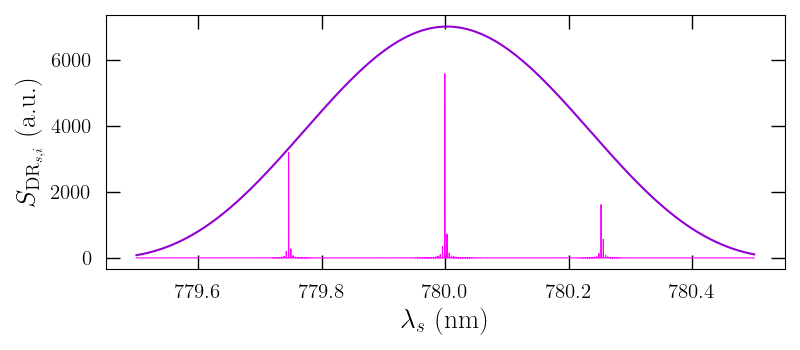

In [6]:
##############################Initialise#####################################################
nrow = 1
ncol = 1
xsize = 8
ysize = 3.5


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


lambda_s_width = 1
lambda_s_center = 780
lambda_i_center = 1/(1/393-1/lambda_s_center)
lambda_i_width = 2*(lambda_i_center-1/(1/393-1/(lambda_s_center+lambda_s_width/2)))

c = 3e8

lambda_s_start = lambda_s_center-lambda_s_width/2 #starting wavelength in nm
lambda_s_end =  lambda_s_center+lambda_s_width/2 #ending wavelength in nm
lambda_i_start = lambda_i_center-lambda_i_width/2 #starting wavelength in nm
lambda_i_end =  lambda_i_center+lambda_i_width/2 #ending wavelength in nm

#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
x_locator = FixedLocator([0])
x_locator = FixedLocator([lambda_s_center-lambda_s_width/4, lambda_s_center, lambda_s_center+lambda_s_width/4])
y_locator = FixedLocator([lambda_i_center-lambda_i_width/4, lambda_i_center, lambda_i_center+lambda_i_width/4])
#y_formatter = FixedFormatter([0,.5,1.00])
#x_locator = FixedLocator([779.5, 780, 780.5])
#y_locator = FixedLocator([791.5, 792, 792.5])


fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.005, wspace=0.005)

fig.set_facecolor('w')

#for i in range(0,len(axes)):
axes.tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
axes.tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
axes.tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
axes.tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
#axes.xaxis.set_major_formatter(x_formatter)
#axes.xaxis.set_major_locator(x_locator)
 #   axes[i,j].yaxis.set_major_formatter(y_formatter)
#    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
#axes[1].set_xticklabels([])
#axes[0].set_xticklabels([])

#############################################################################################
#labels
#axes[0].set_ylabel(r'$S_{\text{DR}_s}$ (a.u.)', fontsize = labelfont)
#axes[1].set_ylabel(r'$S_{\text{DR}_i}$ (a.u.)', fontsize = labelfont)
axes.set_ylabel(r'$S_{\text{DR}_{s,i}}$ (a.u.)', fontsize = labelfont)
axes.set_xlabel(r'$\lambda_s$ (nm)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################



no_pts_s = 50000000
no_pts_i = no_pts_s

omega_s = linspace(c/lambda_s_start/1e-9*2*pi, c/lambda_s_end/1e-9*2*pi, no_pts_s)
omega_i = linspace(c/lambda_i_start/1e-9*2*pi, c/lambda_i_end/1e-9*2*pi, no_pts_i)

lambda_i = c/omega_i/1e-9*2*pi
lambda_s = c/omega_s/1e-9*2*pi

poling_period = 8.35#in um

laser_bw = 0.001 #in nm
laser_center = 393 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(393e-9)**2*laser_bw*1e-9

L = 10 #length of waveguide in mm
l = 75.000021 #length of cavity in mm
r_1 = sqrt(1-0.00075)
r_2 = sqrt(1-0.045)
r_1p = 0.5
r_2p = 0.99

BP_bw_s = 1 #in nm
BP_center_s = 792 #in nm
BP_cnt_f_s = c/BP_center_s/1e-9

BP_HWHM_s = c/(BP_center_s*1e-9)**2*BP_bw_s*1e-9

BP_bw_i = 1 #in nm
BP_center_i = 780 #in nm
BP_cnt_f_i = c/BP_center_i/1e-9

BP_HWHM_i = c/(BP_center_i*1e-9)**2*BP_bw_i*1e-9

###########################################################Calculate dn/dw and n_g
def n_prime(n_array, w_array):
    
    return (gradient(n_array, w_array))

def n_g_x(lambda_in, w_array):
    return add(n_x(lambda_in),w_array * n_prime(n_x(lambda_in), w_array))

def n_g_y(lambda_in, w_array):
    return n_y(lambda_in) + w_array * n_prime(n_y(lambda_in), w_array)

def n_g_z(lambda_in, w_array):
    return n_z(lambda_in) + w_array * n_prime(n_z(lambda_in), w_array)

###########################################Calculate the pump envelope

#alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s_m/(2*pi),omega_i_m/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

###########################################Calculate the spectral intensity

#delta_k = (n_g_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_g_z(lambda_s_m, omega_s_m)/(lambda_s_m*1e-9) - 2*pi*transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k = (2*pi*1.0001335*n_y(2*pi*c/add(omega_i[::-1], omega_s)*1e9)/((2*pi*c/add(omega_i[::-1], omega_s))) - 2*pi*n_z(lambda_s)/(lambda_s*1e-9) - 2*pi*(n_y((lambda_i[::-1])))/(lambda_i[::-1]*1e-9) - 2*pi/poling_period/1e-6)
#delta_k_lin = 2*pi*(n_y(393)/393e-9 - 1/poling_period/1e-6) - 1/c*(omega_s_m*n_z(lambda_s_m)+omega_i_m*n_y(lambda_i_m))

psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

###########################################Calculate the joint spectral intensity

#JSI = (psi*alpha)

###########################################Calculate the filtering airy functions

signal_bw = 2 #in nm
signal_center = 780 #in nm,
signal_cnt_f = c/signal_center/1e-9
signal_FWHM = c/(signal_center*1e-9)**2*signal_bw*1e-9*2*pi

idler_bw = 2 #in nm
idler_center = 792 #in nm,
idler_cnt_f = c/idler_center/1e-9
idler_FWHM = c/(idler_center*1e-9)**2*idler_bw*1e-9*2*pi

#dw = linspace(-4*idler_FWHM,4*idler_FWHM, no_pts_s)

gamma_s = signal_FWHM/2
gamma_i = idler_FWHM/2
#tau = linspace(-8e-12, 8e-12, no_pts_s)

#JSI_s = gamma_s/(gamma_s+1j*(omega_s-omega_s[::-1]))
#JSI_i = gamma_i/(gamma_i+1j*(omega_i-omega_i[::-1]))

phase_s = omega_s*(n_z(lambda_s)*L*1e-3+(l*1e-3-L*1e-3))/3e8
phase_i = omega_i*(n_y(lambda_i)*L*1e-3+(l*1e-3-L*1e-3))/3e8


A_i = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_i)**2))
A_s = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_s)**2))

lambda_s_max = []

#for i in range(2000):
#    lambda_s_max.append(max((JSI**2)[i,:])) 

#axes[0].plot(omega_s-omega_s[::-1], max(A_s)*(psi**2), color = 'red')
#axes[0].plot(omega_s-omega_s[::-1], A_s*(psi**2), lw = 0.8, color = 'red', label = r"$A_sf$")
#axes[0].plot(omega_s-omega_s[::-1], (psi**2), color = 'black')

#axes[1].plot(omega_i-omega_i[::-1], (A_i)*(psi**2), lw = 0.8, color = 'blue')
#axes[1].plot(omega_i-omega_i[::-1], max(A_i)*(psi**2), color = 'mediumblue')
#axes[1].plot(omega_i-omega_i[::-1], (psi**2), color = 'black')

#axes.plot(omega_s-omega_s[::-1], A_s*(psi**2), lw = 0.8, color = 'blue')
axes.plot(lambda_s, A_s*A_i[::-1]*(psi**2), lw = 0.8, color = 'magenta')
#axes.plot(omega_i[::-1]-omega_i, A_i*A_s[::-1][::-1]*(psi**2), lw = 0.8, color = 'magenta')
axes.plot(lambda_s, max(A_i*A_s)*(psi**2), color = 'darkviolet')
#axes[2].plot(omega_i-omega_i[::-1], max(A_i)*(psi**2), '-.', color = 'darkred')
#axes[2].plot(omega_s-omega_s[::-1], max(A_s)*(psi**2), color = 'mediumblue')
#axes[2].plot(omega_i-omega_i[::-1], (psi**2), color = 'black')

matplotlib.pyplot.tight_layout()

lft = 0.15
btm = 0.8

#axes[0].text(lft, btm,r'\textbf{a)}',color = 'black', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
#axes[1].text(lft, btm,r'\textbf{b)}',color = 'black',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
#axes[2].text(lft, btm,r'\textbf{c)}',color = 'black', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)

#axes[0].legend(fontsize = legfont)

<ipython-input-7-8954abbd1a05>:11: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


<IPython.core.display.Javascript object>


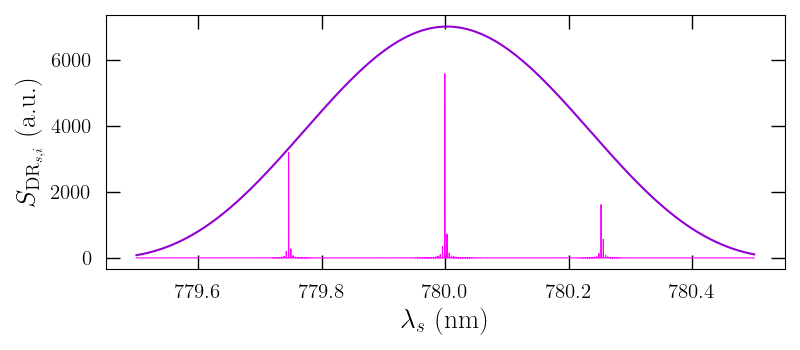

In [7]:
##############################Initialise#####################################################
nrow = 1
ncol = 1
xsize = 8
ysize = 3.5


#############################################################################################
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#set global plotting parameters
linew = 5.0 #line width
#msize = 14 #marker size
axew = 1.0 #axes width

#set the distance to offset the numbers from the ticks
numpad = 10


lambda_s_width = 1
lambda_s_center = 780
lambda_i_center = 1/(1/393-1/lambda_s_center)
lambda_i_width = 2*(lambda_i_center-1/(1/393-1/(lambda_s_center+lambda_s_width/2)))

c = 3e8

lambda_s_start = lambda_s_center-lambda_s_width/2 #starting wavelength in nm
lambda_s_end =  lambda_s_center+lambda_s_width/2 #ending wavelength in nm
lambda_i_start = lambda_i_center-lambda_i_width/2 #starting wavelength in nm
lambda_i_end =  lambda_i_center+lambda_i_width/2 #ending wavelength in nm

#set global tick parameters
majw = axew #major tick width
majl = 10.0 #major tick length
minw = axew #minor tick width
minl = 5.0 #minor tick length

#set global font sizes
axefont = 15 #axis label font size
numsize = 15 #axis number font size
legfont = 15 #legend font size
labelfont=20

#format axis labels
x_locator = FixedLocator([0])
x_locator = FixedLocator([lambda_s_center-lambda_s_width/4, lambda_s_center, lambda_s_center+lambda_s_width/4])
y_locator = FixedLocator([lambda_i_center-lambda_i_width/4, lambda_i_center, lambda_i_center+lambda_i_width/4])
#y_formatter = FixedFormatter([0,.5,1.00])
#x_locator = FixedLocator([779.5, 780, 780.5])
#y_locator = FixedLocator([791.5, 792, 792.5])


fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(xsize,ysize))

fig.subplots_adjust(hspace=0.005, wspace=0.005)

fig.set_facecolor('w')

#for i in range(0,len(axes)):
axes.tick_params(axis='x',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
axes.tick_params(axis='x',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,top='off')
axes.tick_params(axis='y',which='major',width=majw,length=majl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
axes.tick_params(axis='y',which='minor',width=minw,length=minl,labelsize=numsize,zorder=1,direction='in',pad=numpad,right='off')
#axes.xaxis.set_major_formatter(x_formatter)
#axes.xaxis.set_major_locator(x_locator)
 #   axes[i,j].yaxis.set_major_formatter(y_formatter)
#    axes[i].yaxis.set_major_locator(y_locator)
#    axes[i].set_xlim(-15,105)
#    axes[i].set_ylim(-0.1,2.6)
    
#axes[1].set_xticklabels([])
#axes[0].set_xticklabels([])

#############################################################################################
#labels
#axes[0].set_ylabel(r'$S_{\text{DR}_s}$ (a.u.)', fontsize = labelfont)
#axes[1].set_ylabel(r'$S_{\text{DR}_i}$ (a.u.)', fontsize = labelfont)
axes.set_ylabel(r'$S_{\text{DR}_{s,i}}$ (a.u.)', fontsize = labelfont)
axes.set_xlabel(r'$\lambda_s$ (nm)', fontsize = labelfont)

matplotlib.pyplot.tight_layout()
#############################################################################################


###################################
#selmaier for ktp - Sellmeier and thermo-optic dispersion formulas for KTP
#n = a + b/(x^2-c)+d/(x^2-e)
a_x = 3.29100
a_y = 3.45100
a_z = 4.59423
b_x = 0.04140
b_y = 0.04341
b_z = 0.06206
c_x = 0.03978
c_y = 0.04597
c_z = 0.04763
d_x = 9.35522
d_y = 16.98825
d_z = 110.80672
e_x = 31.45571
e_y = 39.43799
e_z = 86.12171

def n_x(lambda_in):
    return  sqrt(a_x+b_x/((lambda_in/1000)**2-c_x)+d_x/((lambda_in/1000)**2-e_x))
def n_y(lambda_in):
    return  sqrt(a_y+b_y/((lambda_in/1000)**2-c_y)+d_y/((lambda_in/1000)**2-e_y))
def n_z(lambda_in):
    return  sqrt(a_z+b_z/((lambda_in/1000)**2-c_z)+d_z/((lambda_in/1000)**2-e_z))

###################################



no_pts_s = 50000000
no_pts_i = no_pts_s

omega_s = linspace(c/lambda_s_start/1e-9*2*pi, c/lambda_s_end/1e-9*2*pi, no_pts_s)
omega_i = linspace(c/lambda_i_start/1e-9*2*pi, c/lambda_i_end/1e-9*2*pi, no_pts_i)

lambda_i = c/omega_i/1e-9*2*pi
lambda_s = c/omega_s/1e-9*2*pi

poling_period = 8.35#in um

laser_bw = 0.001 #in nm
laser_center = 393 #in nm,
laser_cnt_f = c/laser_center/1e-9

laserHWHM = c/(393e-9)**2*laser_bw*1e-9

L = 10 #length of waveguide in mm
l = 75.000021 #length of cavity in mm
r_1 = sqrt(1-0.00075)
r_2 = sqrt(1-0.045)
r_1p = 0.5
r_2p = 0.99

BP_bw_s = 1 #in nm
BP_center_s = 792 #in nm
BP_cnt_f_s = c/BP_center_s/1e-9

BP_HWHM_s = c/(BP_center_s*1e-9)**2*BP_bw_s*1e-9

BP_bw_i = 1 #in nm
BP_center_i = 780 #in nm
BP_cnt_f_i = c/BP_center_i/1e-9

BP_HWHM_i = c/(BP_center_i*1e-9)**2*BP_bw_i*1e-9

###########################################################Calculate dn/dw and n_g
def n_prime(n_array, w_array):
    
    return (gradient(n_array, w_array))

def n_g_x(lambda_in, w_array):
    return add(n_x(lambda_in),w_array * n_prime(n_x(lambda_in), w_array))

def n_g_y(lambda_in, w_array):
    return n_y(lambda_in) + w_array * n_prime(n_y(lambda_in), w_array)

def n_g_z(lambda_in, w_array):
    return n_z(lambda_in) + w_array * n_prime(n_z(lambda_in), w_array)

###########################################Calculate the pump envelope

#alpha = exp(-1*array([x - laser_cnt_f for x in (add(omega_s_m/(2*pi),omega_i_m/(2*pi)))])**2/(2*(2*laserHWHM/2.35482)**2))

###########################################Calculate the spectral intensity

#delta_k = (n_g_y(2*pi*c/add(omega_i_m, omega_s_m)*1e9,add(omega_i_m, omega_s_m))/((2*pi*c/add(omega_i_m, omega_s_m))) - 2*pi*n_g_z(lambda_s_m, omega_s_m)/(lambda_s_m*1e-9) - 2*pi*transpose(n_g_y(transpose(lambda_i_m), transpose(omega_i_m)))/(lambda_i_m*1e-9) - 2*pi/poling_period/1e-6)
delta_k = (2*pi*1.0001335*n_y(2*pi*c/add(omega_i[::-1], omega_s)*1e9)/((2*pi*c/add(omega_i[::-1], omega_s))) - 2*pi*n_z(lambda_s)/(lambda_s*1e-9) - 2*pi*(n_y((lambda_i[::-1])))/(lambda_i[::-1]*1e-9) - 2*pi/poling_period/1e-6)
#delta_k_lin = 2*pi*(n_y(393)/393e-9 - 1/poling_period/1e-6) - 1/c*(omega_s_m*n_z(lambda_s_m)+omega_i_m*n_y(lambda_i_m))

psi = (sin(delta_k*L*1e-3/2)/(delta_k*L*1e-3/2))

###########################################Calculate the joint spectral intensity

#JSI = (psi*alpha)

###########################################Calculate the filtering airy functions

signal_bw = 2 #in nm
signal_center = 780 #in nm,
signal_cnt_f = c/signal_center/1e-9
signal_FWHM = c/(signal_center*1e-9)**2*signal_bw*1e-9*2*pi

idler_bw = 2 #in nm
idler_center = 792 #in nm,
idler_cnt_f = c/idler_center/1e-9
idler_FWHM = c/(idler_center*1e-9)**2*idler_bw*1e-9*2*pi

#dw = linspace(-4*idler_FWHM,4*idler_FWHM, no_pts_s)

gamma_s = signal_FWHM/2
gamma_i = idler_FWHM/2
#tau = linspace(-8e-12, 8e-12, no_pts_s)

#JSI_s = gamma_s/(gamma_s+1j*(omega_s-omega_s[::-1]))
#JSI_i = gamma_i/(gamma_i+1j*(omega_i-omega_i[::-1]))

phase_s = omega_s*(n_z(lambda_s)*L*1e-3+(l*1e-3-L*1e-3))/3e8
phase_i = omega_i*(n_y(lambda_i)*L*1e-3+(l*1e-3-L*1e-3))/3e8


A_i = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_i)**2))
A_s = ((1-r_2**2)/(1-r_1*r_2)**2) * (1)/(1+(4*r_1*r_2/(1-r_1*r_2)**2*sin(phase_s)**2))

lambda_s_max = []

#for i in range(2000):
#    lambda_s_max.append(max((JSI**2)[i,:])) 

#axes[0].plot(omega_s-omega_s[::-1], max(A_s)*(psi**2), color = 'red')
#axes[0].plot(omega_s-omega_s[::-1], A_s*(psi**2), lw = 0.8, color = 'red', label = r"$A_sf$")
#axes[0].plot(omega_s-omega_s[::-1], (psi**2), color = 'black')

#axes[1].plot(omega_i-omega_i[::-1], (A_i)*(psi**2), lw = 0.8, color = 'blue')
#axes[1].plot(omega_i-omega_i[::-1], max(A_i)*(psi**2), color = 'mediumblue')
#axes[1].plot(omega_i-omega_i[::-1], (psi**2), color = 'black')

#axes.plot(omega_s-omega_s[::-1], A_s*(psi**2), lw = 0.8, color = 'blue')
axes.plot(lambda_s, A_s*A_i[::-1]*(psi**2), lw = 0.8, color = 'magenta')
#axes.plot(omega_i[::-1]-omega_i, A_i*A_s[::-1][::-1]*(psi**2), lw = 0.8, color = 'magenta')
axes.plot(lambda_s, max(A_i*A_s)*(psi**2), color = 'darkviolet')
#axes[2].plot(omega_i-omega_i[::-1], max(A_i)*(psi**2), '-.', color = 'darkred')
#axes[2].plot(omega_s-omega_s[::-1], max(A_s)*(psi**2), color = 'mediumblue')
#axes[2].plot(omega_i-omega_i[::-1], (psi**2), color = 'black')

matplotlib.pyplot.tight_layout()

lft = 0.15
btm = 0.8

#axes[0].text(lft, btm,r'\textbf{a)}',color = 'black', horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes, fontsize = labelfont)
#axes[1].text(lft, btm,r'\textbf{b)}',color = 'black',horizontalalignment='center', verticalalignment='center' , transform = axes[1].transAxes, fontsize = labelfont)
#axes[2].text(lft, btm,r'\textbf{c)}',color = 'black', horizontalalignment='center', verticalalignment='center', transform = axes[2].transAxes, fontsize = labelfont)

#axes[0].legend(fontsize = legfont)

<IPython.core.display.Javascript object>


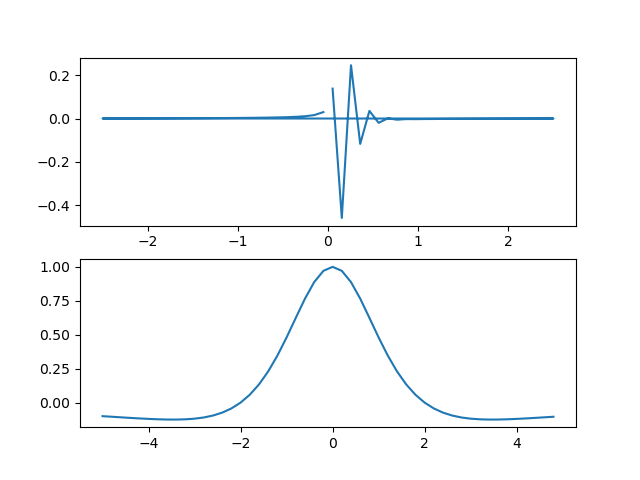

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [4]:
import scipy.fft
from scipy import signal
# Number of sample points
N = 50
# sample spacing
Fs = 10
xf = fftfreq(N,1/Fs)
xf = fftshift(xf)
gamma_i = 2
gamma_s = 2
yf = gamma_s/(gamma_s+1j*xf)*gamma_i/(gamma_i+1j*xf)
#yf = exp(-xf**2)*sin(xf*8)/(8*xf)*exp(8*xf*1j)
y = ifft(yf)
x = np.linspace(-N/Fs/2, N/Fs/2, N)
x = fftshift(x)
fig, axes = plt.subplots(nrows = 2, ncols = 1)

axes[0].plot(x,y)
axes[1].plot(xf,yf)


<IPython.core.display.Javascript object>


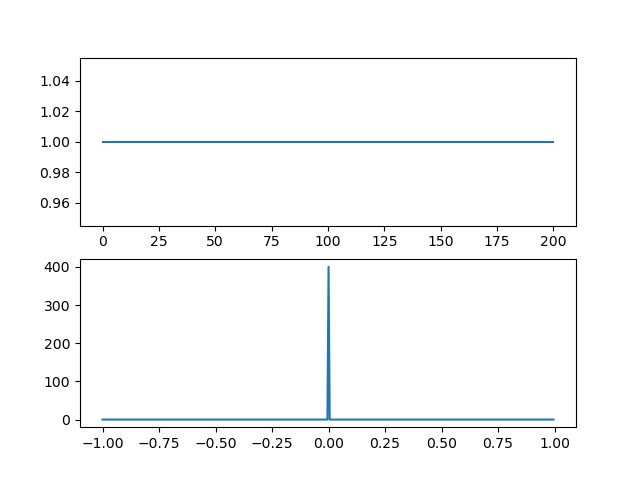

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [2]:
from scipy.fft import fft, fftfreq, fftshift
# number of signal points
N = 400
# sample spacing
T = 1.0 / 2.0
x = np.linspace(0.0, N*T, N)
y = ones(len(x))
yf = fft(y)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)

fig, axes = plt.subplots(nrows = 2, ncols = 1)

axes[0].plot(x,ifft(yf))
axes[1].plot(xf,yplot)
